In [1]:
from glob import glob
import os
import torch

def get_model_name(path: str) -> str:
    return os.path.splitext(os.path.basename(path))[0]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# If it is not finding your model file (.pt), try checking the surrounding directories and placing/creating 
# the .pt in the directory it's looking for e.g. ./TrainingResults/ResNet18/2021-05-02-1000/resnet18_pretrained.pt
models = {get_model_name(p): torch.load(p, "cpu") for p in glob("./TrainingResults/**/**/*.pt")}
for modelname, model in models.items():
    if not modelname.startswith("covidnet"):
        for p in model.parameters():
            p.requires_grad = False
    model.eval()


In [2]:
sorted(models.keys())

['covidnet_trained',
 'covidnetlstm_trained',
 'densenet121_pretrained',
 'inceptionv3_pretrained',
 'resnet18_pretrained',
 'resnet50_pretrained',
 'squeezenet1-1_pretrained']

In [3]:
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import warnings
from PIL import Image
from termcolor import colored
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


class_names = ['covid','non']

sm = torch.nn.Softmax()

# Based on DeepCovid code base
############### Get the predicted probabilities of all samples

def test_model(name, model, loader):
    model = model.to(device)
    start_time = time.time()
    Y_pred, Y_test = [], []
    warnings.filterwarnings("ignore")

    for images, target in loader:
        images = images.to(device)
        model_start = time.time()
        outputs = model(images)
        model_time = time.time() - model_start
        outputs = outputs.cpu().detach()

        Y_pred.append(outputs)
        Y_test.append(target)

    y_pred = torch.cat(Y_pred)
    y_test = torch.cat(Y_test)
    covid_count = y_test.argmax()

    covid_prob = sm(y_pred[:covid_count, :])[:, 0]
    non_prob   = sm(y_pred[covid_count:, :])[:, 0]
    end_time = time.time()
    tot_time = end_time- start_time
    print(f"Tested {name} in {tot_time:.3f}s")

    return covid_prob, non_prob

In [4]:
batch_size = 100

test_data_path = 'data/test'

test_covid_prob, test_non_prob = {}, {}
for model_name, model in models.items():
    if model_name == "InceptionV3":
        img_size = 299
        data_transforms = transforms.Compose([
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        img_size = 224
        data_transforms = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    test_folder = ImageFolder(test_data_path, data_transforms)
    test_loader = DataLoader(test_folder, batch_size=batch_size)
    test_covid_prob[model_name], test_non_prob[model_name] = test_model(model_name, model, test_loader)
  

Tested covidnet_trained in 16.939s
Tested densenet121_pretrained in 23.158s
Tested inceptionv3_pretrained in 19.614s
Tested resnet18_pretrained in 16.768s
Tested resnet50_pretrained in 22.404s
Tested squeezenet1-1_pretrained in 15.191s
Tested covidnetlstm_trained in 16.278s


In [5]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn


thresh = 0.36

# Based on DeepCovid code
############### derive labels based on probabilities and cut-off threshold

def plot_confusion_matrix(ax, name, covid_prob, non_prob):
    y_pred = torch.cat([covid_prob > thresh, non_prob > thresh]).int()
    y_test = torch.cat([torch.ones(len(covid_prob)), torch.zeros(len(non_prob))]).int()

    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)   

    # Plot normalized confusion matrix

    df_cm = pd.DataFrame(cnf_matrix, index=[i for i in class_names], columns=[i for i in class_names])

    hm = sn.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, cbar=False, fmt='g', xticklabels=['Pred Non-COVID','Pred COVID-2019'], yticklabels= ['True Non-COVID','True COVID-2019'], ax=ax)
    hm.set_title(name)


In [6]:
from matplotlib.transforms import Bbox

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)


def save_ax(fig, ax, filename):
    # https://stackoverflow.com/questions/4325733/save-a-subplot-in-matplotlib
    # Save just the portion _inside_ the second axis's boundaries
    extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
    # Alternatively,
    # extent = ax.get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, bbox_inches=extent)

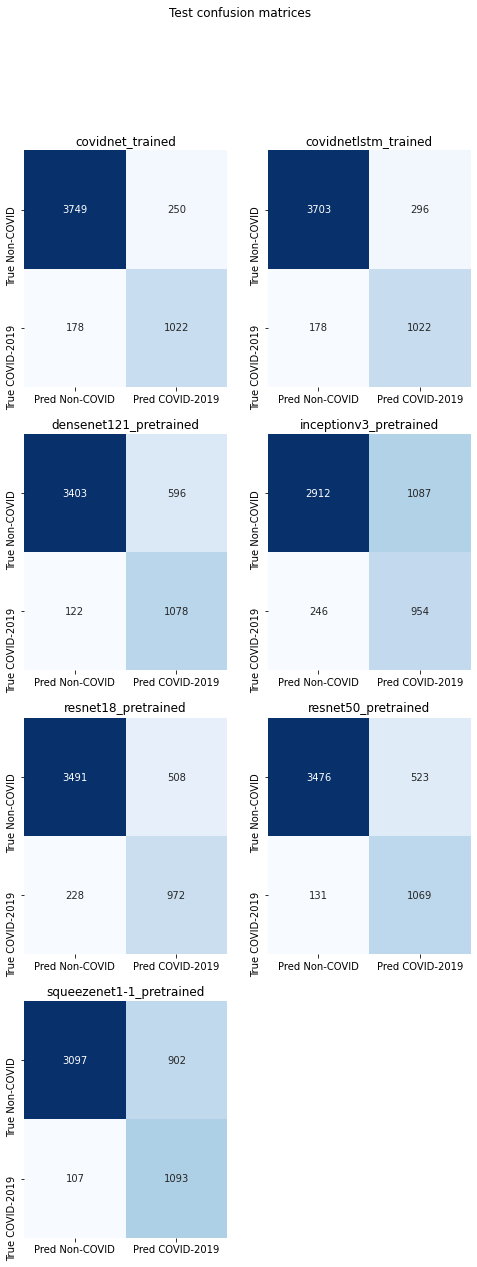

In [7]:
NUM_OF_COLS = 2
NUM_OF_ROWS = (len(models) + NUM_OF_COLS - 1) // NUM_OF_COLS
fig = plt.figure(figsize=(4*NUM_OF_COLS, 5*NUM_OF_ROWS))
fig.suptitle("Test confusion matrices")
for i, model_name in enumerate(sorted(models.keys()), start=1):
    ax = fig.add_subplot(NUM_OF_ROWS, NUM_OF_COLS, i)
    plot_confusion_matrix(ax, model_name, test_covid_prob[model_name], test_non_prob[model_name])
    save_ax(fig, ax, f"{model_name}_cm.png")    

In [8]:
# Based on DeepCovid code
############### ROC Curve and AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(model_name, covid_prob, non_prob):
    y_test = torch.cat([torch.ones(len(covid_prob)), torch.zeros(len(non_prob))])
    y_pred = torch.cat([covid_prob, non_prob])
            
    auc = roc_auc_score(y_test, y_pred)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, y_pred)

    plt.plot(ns_fpr, ns_tpr, linewidth=2, label=f"{model_name}\nAUC={auc:.3f}")
    plt.ylim([0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend(loc='lower right')


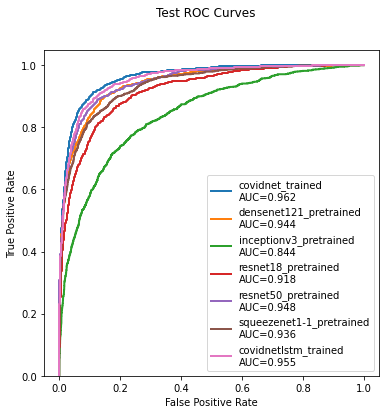

In [9]:
fig = plt.figure(figsize=[6, 6])
fig.suptitle("Test ROC Curves")
for model_name in models.keys():
    plot_roc_curve(model_name, test_covid_prob[model_name], test_non_prob[model_name])
    plt.savefig("test_roc.png")

In [10]:
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
import pandas as pd
import matplotlib.table
import seaborn as sn

# Based on DeepCovid Code
############### derive labels based on probabilities and cut-off threshold

def print_scores(dataset_name, covid_probs, non_probs):
    cell_text = []
    
    model_names = sorted(covid_probs.keys())
    for model_name in model_names:
        covid_prob = covid_probs[model_name]
        non_prob = non_probs[model_name]

        covid_pred = (covid_prob > thresh).int()
        covid_true = torch.ones(len(covid_prob))

        non_pred = (non_prob > thresh).int()
        non_true = torch.zeros(len(non_prob))

        sensitivity = recall_score(covid_true, covid_pred)
        specificity = recall_score(1-non_true, 1-non_pred)

        y_pred = torch.cat([covid_pred, non_pred])
        y_true = torch.cat([covid_true, non_true])

        precision = precision_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
    
        cell_text.append([f"{n:.3f}" for n in [sensitivity, specificity, precision, accuracy, f1]])

    fig, ax = plt.subplots(figsize=(10, 10))
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    col_labels = ["Sensitivity", "Specificity", "Precision", "Accuracy", "F1"]
    table = matplotlib.table.table(ax=ax, cellText=cell_text, rowLabels=model_names, colLabels=col_labels, loc="center")
    table.scale(1,3)
    table.set_fontsize(20)

    return cell_text

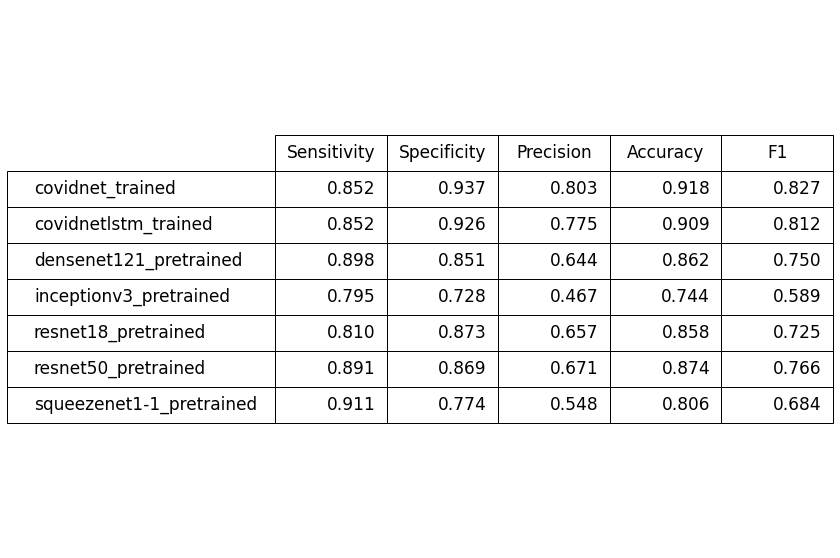

In [11]:
cell_text = print_scores("Testing", test_covid_prob, test_non_prob)

In [12]:
for row in cell_text:
    print(",".join(row))

0.852,0.937,0.803,0.918,0.827
0.852,0.926,0.775,0.909,0.812
0.898,0.851,0.644,0.862,0.750
0.795,0.728,0.467,0.744,0.589
0.810,0.873,0.657,0.858,0.725
0.891,0.869,0.671,0.874,0.766
0.911,0.774,0.548,0.806,0.684


In [13]:
def plot_probabilities(model_name, covid_prob, non_prob):
    fig, axs = plt.subplots(2)
    bins = np.linspace(0, 1, 25)
    fig.suptitle(model_name)
    
    axs[0].hist(covid_prob, bins, color='blue', histtype = 'bar', label='Probabilities of COVID-19 Samples')
    axs[0].legend(loc='upper center')
    axs[1].hist(non_prob, bins, color='green', label='Probabilities of Non-COVID Samples')
    axs[1].legend(loc='upper center')
    plt.savefig(f'{model_name}_probabilities.png')

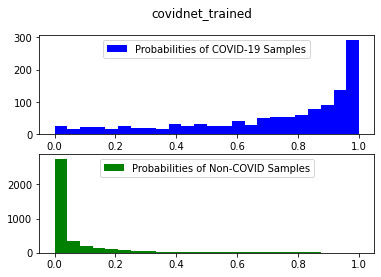

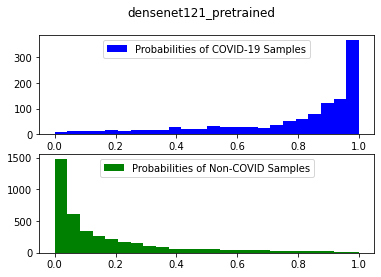

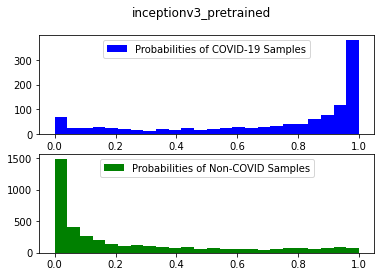

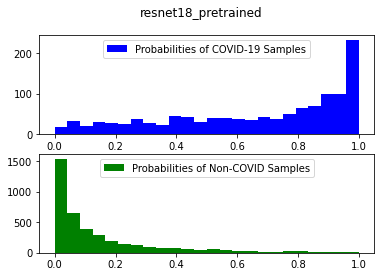

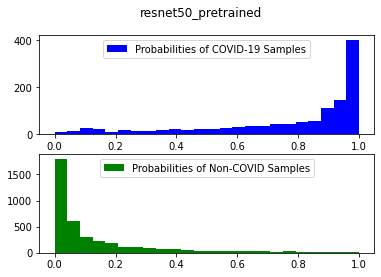

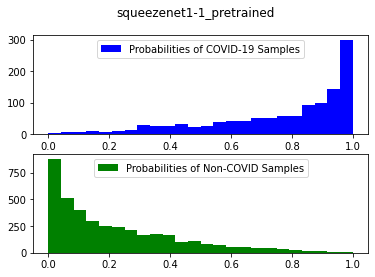

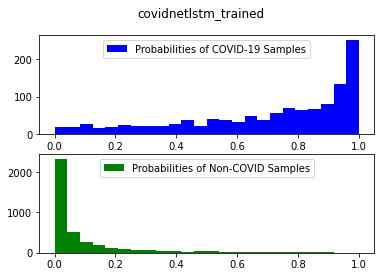

In [14]:
for name in models.keys():
    plot_probabilities(name, test_covid_prob[name].tolist(), test_non_prob[name].tolist())